# Continuous Control

---

In this notebook, we use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# when running in Udacity workspace
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from unityagents import UnityEnvironment

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. The State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

### 3. DDPG Model

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
def ddpg(n_episodes=200, max_t=1000, solved_score=30.0, consec_episodes=100, print_every=1, train_mode=True,
         actor_path='actor_ckpt.pth', critic_path='critic_ckpt.pth'):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        solved_score (float)  : min avg score over consecutive episodes
        consec_episodes (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor network weights
        critic_path (str)     : directory to store critic network weights

    """
    instant_scores = [] 
    scores_window = deque(maxlen=consec_episodes)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        instant_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(instant_scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} \tInst. Reward: {:.1f}\tAvg. Reward: {:.1f}'.format(\
                  i_episode, instant_scores[-1], moving_avgs[-1]))
                  
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    i_episode-consec_episodes, moving_avgs[-1], consec_episodes))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), actor_path)
                torch.save(agent.critic_local.state_dict(), critic_path)  
            break
            
    return instant_scores, moving_avgs

In [7]:
# run the training loop
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
scores, avgs = ddpg()

Episode 1 	Inst. Reward: 1.1	Avg. Reward: 1.1
Episode 2 	Inst. Reward: 0.9	Avg. Reward: 1.0
Episode 3 	Inst. Reward: 1.0	Avg. Reward: 1.0
Episode 4 	Inst. Reward: 1.1	Avg. Reward: 1.0
Episode 5 	Inst. Reward: 1.6	Avg. Reward: 1.1
Episode 6 	Inst. Reward: 0.2	Avg. Reward: 1.0
Episode 7 	Inst. Reward: 1.7	Avg. Reward: 1.1
Episode 8 	Inst. Reward: 0.3	Avg. Reward: 1.0
Episode 9 	Inst. Reward: 0.9	Avg. Reward: 1.0
Episode 10 	Inst. Reward: 0.1	Avg. Reward: 0.9
Episode 11 	Inst. Reward: 0.9	Avg. Reward: 0.9
Episode 12 	Inst. Reward: 0.2	Avg. Reward: 0.9
Episode 13 	Inst. Reward: 0.5	Avg. Reward: 0.8
Episode 14 	Inst. Reward: 0.2	Avg. Reward: 0.8
Episode 15 	Inst. Reward: 1.3	Avg. Reward: 0.8
Episode 16 	Inst. Reward: 1.2	Avg. Reward: 0.8
Episode 17 	Inst. Reward: 1.7	Avg. Reward: 0.9
Episode 18 	Inst. Reward: 1.4	Avg. Reward: 0.9
Episode 19 	Inst. Reward: 2.2	Avg. Reward: 1.0
Episode 20 	Inst. Reward: 0.9	Avg. Reward: 1.0
Episode 21 	Inst. Reward: 2.1	Avg. Reward: 1.0
Episode 22 	Inst. Rewa

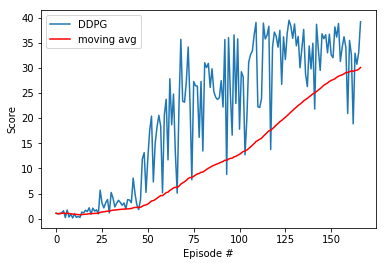

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [9]:
env.close()